# Meteorite Discovery Analysis: Geographic Patterns & Discovery Bias

This notebook investigates **geographic and temporal patterns** in meteorite discoveries to understand how human activity, rather than actual meteorite distribution, shapes what we find.

## Three Research Questions:

1. **Discovery Bias: Geographic & Temporal Patterns** (Primary)
   - How do discovery patterns reflect human activity rather than actual meteorite distribution?
   - Do discovery rates correlate with population density and accessibility over time?
   - How has the geographic distribution changed from 1800s to present?
   - Do "Fell" (observed) vs "Found" (discovered later) meteorites show different geographic clustering?

2. **Meteorite Type Distribution: Compositional Patterns** (Secondary)
   - Do different meteorite types show distinct geographic or temporal patterns?
   - Are certain meteorite classes more common in specific regions (e.g., Antarctica vs deserts)?
   - Has the diversity of meteorite types discovered increased over time?

3. **Mass Distribution: Survivability & Discovery Bias** (Tertiary)
   - What patterns in meteorite mass reveal about atmospheric entry, survivability, and discovery methods?
   - Do larger meteorites survive better in certain environments?
   - Has the average mass of discovered meteorites changed over time?

## Why This Matters

Meteorite collections are heavily biased by:
- **Human population density** - more discoveries where people live
- **Accessibility** - systematic searches in Antarctica, deserts
- **Technology** - modern detection methods reveal different patterns
- **Historical events** - wars, expeditions, scientific programs

Understanding these biases is crucial for interpreting scientific datasets.

## Setup Instructions

Install required packages:
```bash
pip install pandas numpy matplotlib seaborn scipy
```

Then run all cells sequentially.

In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Cell 2: Load and Initial Exploration
df = pd.read_csv('../raw/Meteorite_Landings.csv')
print(f"Total records: {len(df)}")

# Clean data: remove missing coordinates or invalid years
df_clean = df.dropna(subset=['reclat', 'reclong', 'year']).copy()
df_clean = df_clean[df_clean['year'] > 0]
# Remove future dates (data quality issue)
df_clean = df_clean[df_clean['year'] <= 2024]
print(f"Valid records (with coordinates & valid year): {len(df_clean)}")

# Basic statistics
print(f"\nYear range: {int(df_clean['year'].min())} to {int(df_clean['year'].max())}")
print(f"\nFell vs Found:")
print(df_clean['fall'].value_counts())
print(f"\nFell percentage: {(df_clean['fall']=='Fell').sum() / len(df_clean) * 100:.2f}%")

# Meteorite types
print(f"\nUnique meteorite types: {df_clean['recclass'].nunique()}")
print(f"\nTop 10 meteorite types:")
print(df_clean['recclass'].value_counts().head(10))

# Mass statistics
mass_clean = df_clean[df_clean['mass (g)'].notna()]
print(f"\nMeteorites with mass data: {len(mass_clean)} ({len(mass_clean)/len(df_clean)*100:.1f}%)")
if len(mass_clean) > 0:
    print(f"Mass range: {mass_clean['mass (g)'].min():.2f}g to {mass_clean['mass (g)'].max():.2e}g")
    print(f"Median mass: {mass_clean['mass (g)'].median():.2f}g")

print(f"\nSample of data:")
df_clean[['name', 'year', 'fall', 'recclass', 'reclat', 'reclong', 'mass (g)']].head(10)

Total records: 45716
Valid records (with coordinates & valid year): 38222

Year range: 860 to 2013

Fell vs Found:
fall
Found    37125
Fell      1097
Name: count, dtype: int64

Fell percentage: 2.87%

Unique meteorite types: 424

Top 10 meteorite types:
recclass
L6      7525
H5      6247
H6      3898
H4      3880
L5      3266
LL5     2199
LL6     1660
L4       939
H4/5     395
CM2      332
Name: count, dtype: int64

Meteorites with mass data: 38114 (99.7%)
Mass range: 0.00g to 6.00e+07g
Median mass: 29.09g

Sample of data:


,name,year,fall,recclass,reclat,reclong,mass (g)
0,Aachen,1880.0,Fell,L5,50.77500,6.08333,21.0
1,Aarhus,1951.0,Fell,H6,56.18333,10.23333,720.0
2,Abee,1952.0,Fell,EH4,54.21667,-113.00000,107000.0
3,Acapulco,1976.0,Fell,Acapulcoite,16.88333,-99.90000,1914.0
4,Achiras,1902.0,Fell,L6,-33.16667,-64.95000,780.0
5,Adhi Kot,1919.0,Fell,EH4,32.10000,71.80000,4239.0
6,Adzhi-Bogdo (stone),1949.0,Fell,LL3-6,44.83333,95.16667,910.0
7,Agen,1814.0,Fell,H5,44.21667,0.61667,30000.0
8,Aguada,1930.0,Fell,L6,-31.60000,-65.23333,1620.0
9,Aguila Blanca,1920.0,Fell,L,-30.86667,-64.55000,1440.0


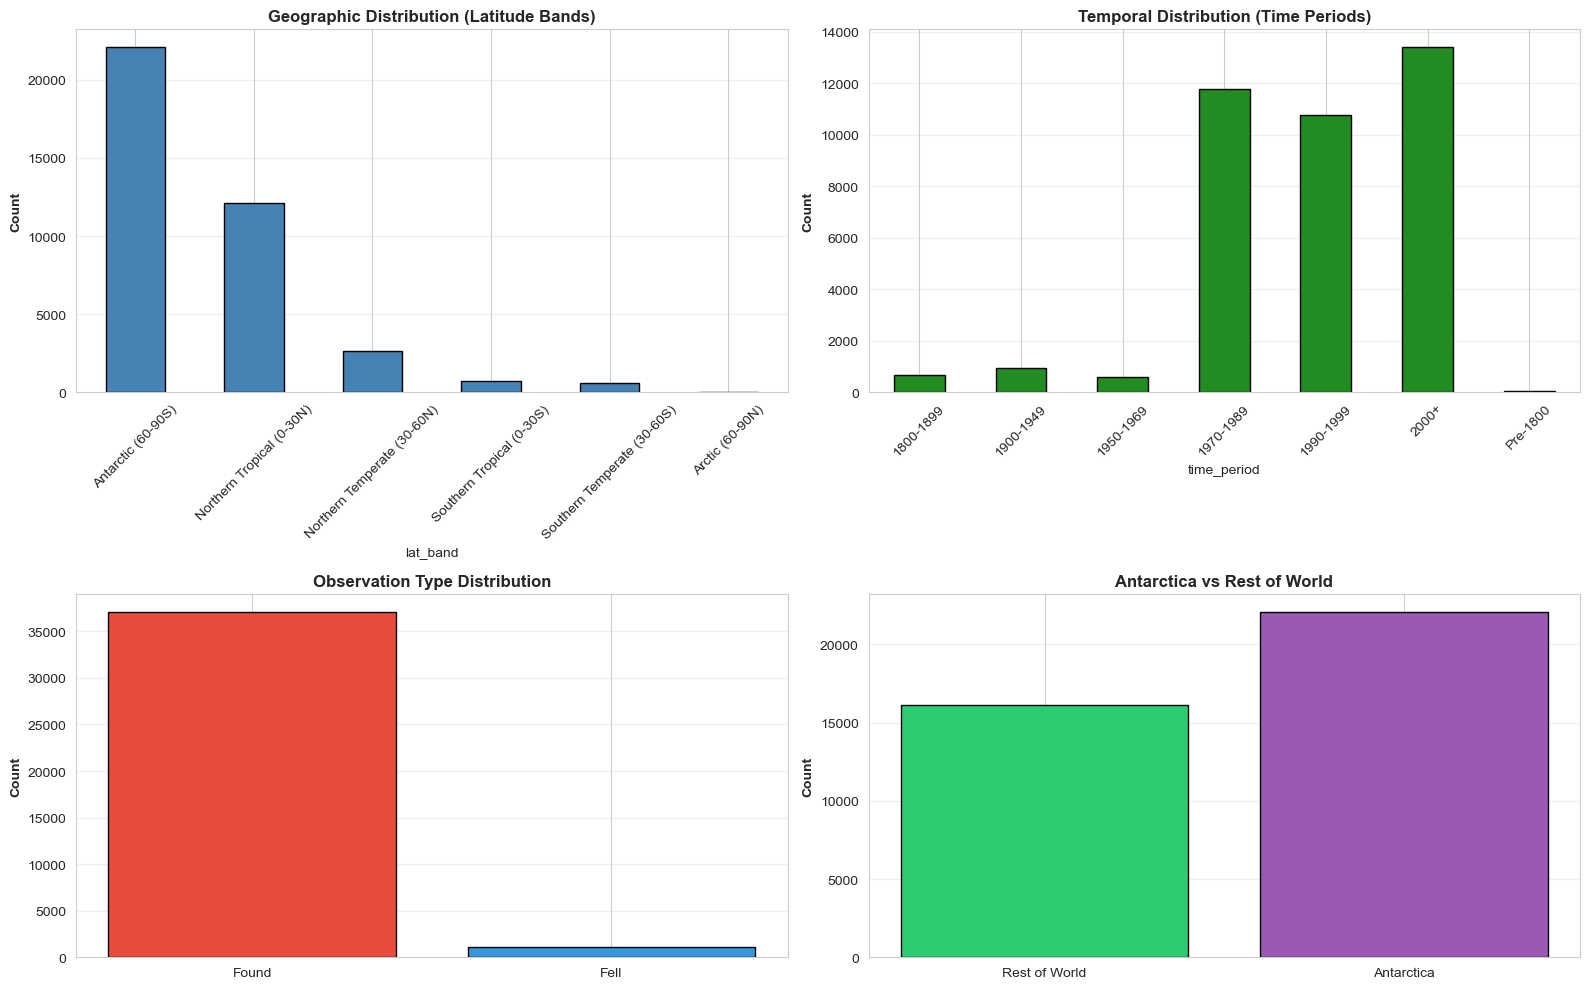

✓ Created analysis categories:
  - 6 geographic regions
  - 7 time periods
  - 2 observation types
  - Antarctica: 22099 meteorites (57.8%)


In [3]:
# Cell 3: Create Geographic and Temporal Categories

# Geographic strata (latitude bands)
def assign_lat_band(lat):
    if lat >= 60:
        return 'Arctic (60-90N)'
    elif lat >= 30:
        return 'Northern Temperate (30-60N)'
    elif lat >= 0:
        return 'Northern Tropical (0-30N)'
    elif lat >= -30:
        return 'Southern Tropical (0-30S)'
    elif lat >= -60:
        return 'Southern Temperate (30-60S)'
    else:
        return 'Antarctic (60-90S)'

df_clean['lat_band'] = df_clean['reclat'].apply(assign_lat_band)

# Temporal strata (time periods) - key historical periods
def assign_time_period(year):
    if year < 1800:
        return 'Pre-1800'
    elif year < 1900:
        return '1800-1899'
    elif year < 1950:
        return '1900-1949'
    elif year < 1970:
        return '1950-1969'  # Post-WWII, early space age
    elif year < 1990:
        return '1970-1989'  # Antarctic expeditions accelerate
    elif year < 2000:
        return '1990-1999'
    else:
        return '2000+'

df_clean['time_period'] = df_clean['year'].apply(assign_time_period)

# Create decade column for temporal analysis
df_clean['decade'] = (df_clean['year'] // 10) * 10

# Identify Antarctica (major bias source - systematic searches)
df_clean['is_antarctica'] = df_clean['reclat'] < -60

# Visualize initial distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Geographic distribution
lat_counts = df_clean['lat_band'].value_counts()
lat_counts.plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Geographic Distribution (Latitude Bands)', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Temporal distribution
time_counts = df_clean['time_period'].value_counts().sort_index()
time_counts.plot(kind='bar', ax=axes[0, 1], color='forestgreen', edgecolor='black')
axes[0, 1].set_title('Temporal Distribution (Time Periods)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Fell vs Found
fall_counts = df_clean['fall'].value_counts()
axes[1, 0].bar(fall_counts.index, fall_counts.values, color=['#e74c3c', '#3498db'], edgecolor='black')
axes[1, 0].set_title('Observation Type Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Antarctica vs Rest of World
ant_counts = df_clean['is_antarctica'].value_counts()
axes[1, 1].bar(['Rest of World', 'Antarctica'], 
               [ant_counts.get(False, 0), ant_counts.get(True, 0)],
               color=['#2ecc71', '#9b59b6'], edgecolor='black')
axes[1, 1].set_title('Antarctica vs Rest of World', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"✓ Created analysis categories:")
print(f"  - {df_clean['lat_band'].nunique()} geographic regions")
print(f"  - {df_clean['time_period'].nunique()} time periods")
print(f"  - {df_clean['fall'].nunique()} observation types")
print(f"  - Antarctica: {df_clean['is_antarctica'].sum()} meteorites ({df_clean['is_antarctica'].sum()/len(df_clean)*100:.1f}%)")

# Analysis 1: Discovery Bias - Geographic & Temporal Patterns

**Research Question:** How do meteorite discovery patterns reflect human activity rather than actual meteorite distribution?

**Key Hypotheses:**
- Discoveries should cluster where people live (population density bias)
- Antarctica should show different patterns (systematic searches vs random finds)
- "Fell" (observed) meteorites should be more common in populated areas
- Discovery rates should increase dramatically after systematic Antarctic expeditions (1970s+)

DISCOVERIES BY DECADE AND LATITUDE BAND (1800+)
lat_band  Arctic (60-90N)  Northern Temperate (30-60N)  Northern Tropical (0-30N)  Southern Tropical (0-30S)  Southern Temperate (30-60S)  Antarctic (60-90S)
decade                                                                                                                                                       
1800.0                  0                           16                          4                          1                            0                   0
1810.0                  2                           24                          4                          0                            0                   0
1820.0                  0                           23                          5                          1                            0                   0
1830.0                  0                           25                          5                          2                            1                   0
1840

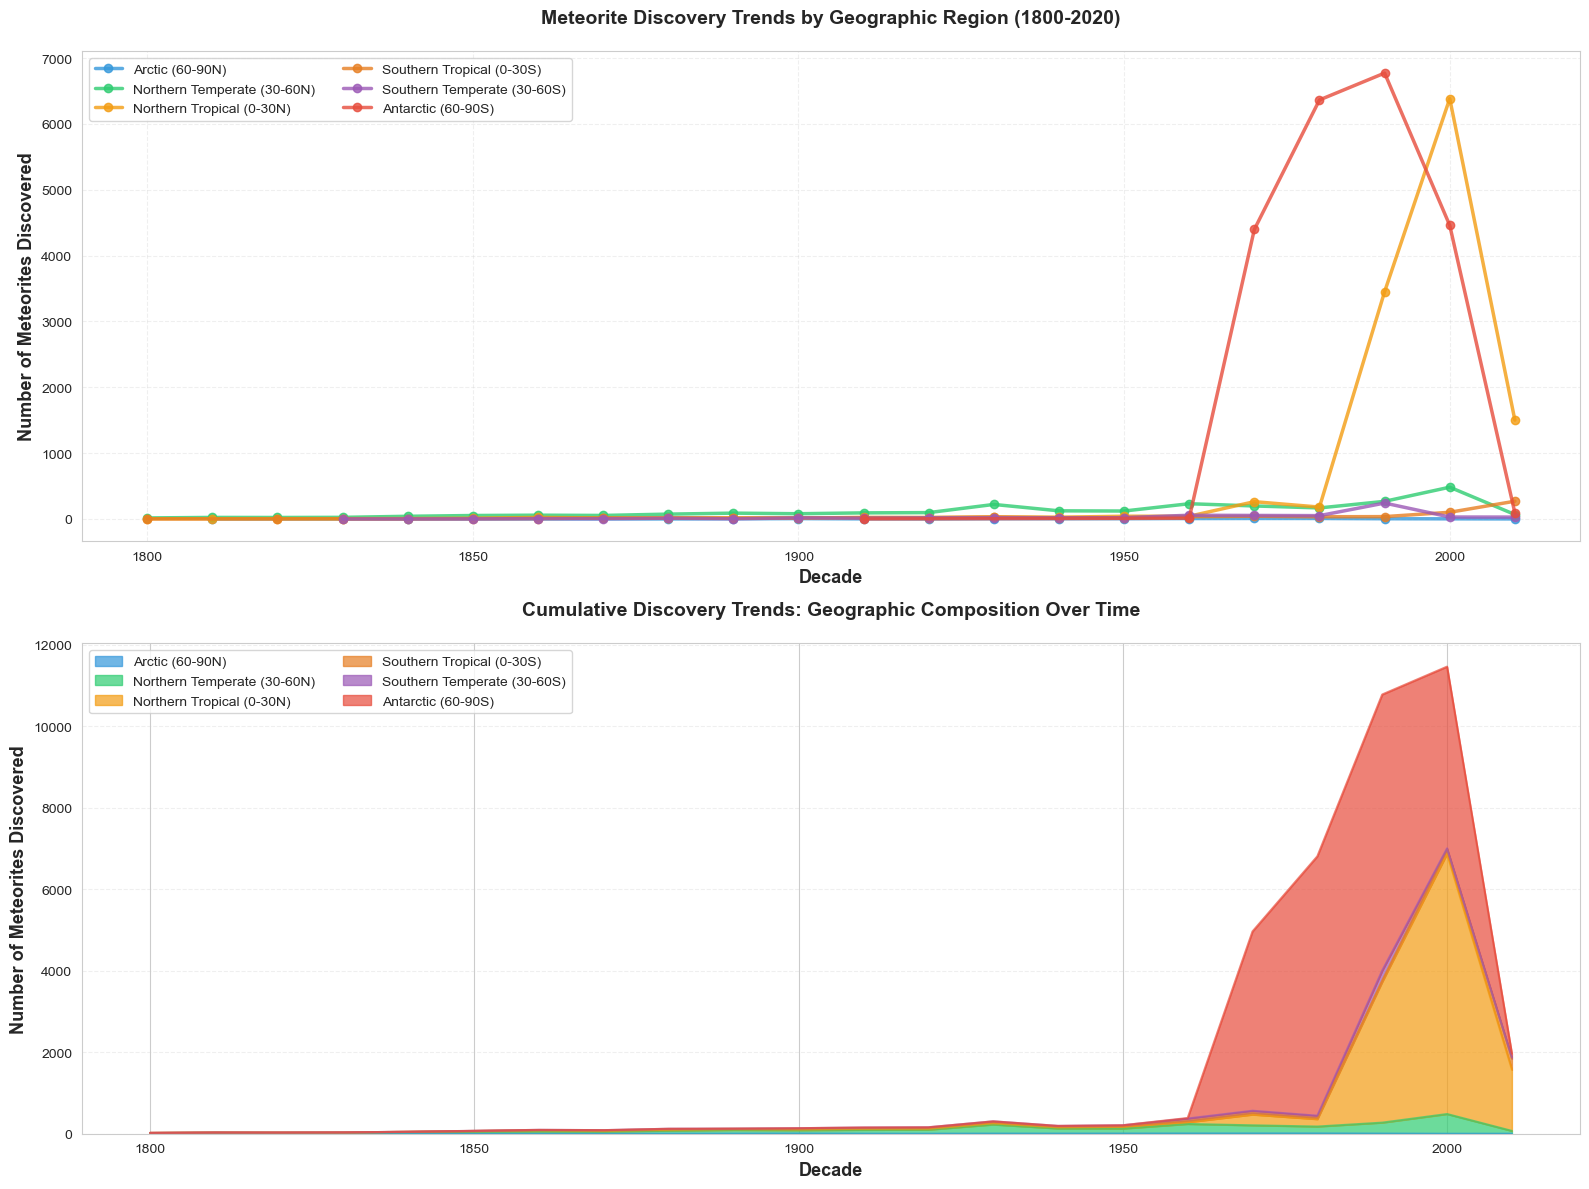


Key Insight: Notice the dramatic increase in Antarctic discoveries starting in the 1970s!
This reflects systematic search programs, not actual meteorite distribution.


In [ ]:
# 1.1: Global Geographic Distribution Over Time

# Create visualization of discoveries by decade and region
df_recent = df_clean[df_clean['year'] >= 1800].copy()

# Aggregate by decade and latitude band
decade_geo = df_recent.groupby(['decade', 'lat_band']).size().reset_index(name='count')
decade_total = df_recent.groupby('decade').size().reset_index(name='total')

# Create pivot table
pivot_geo = decade_geo.pivot(index='decade', columns='lat_band', values='count').fillna(0)

# Reorder columns
lat_order = ['Arctic (60-90N)', 'Northern Temperate (30-60N)', 'Northern Tropical (0-30N)',
             'Southern Tropical (0-30S)', 'Southern Temperate (30-60S)', 'Antarctic (60-90S)']
pivot_geo = pivot_geo[[col for col in lat_order if col in pivot_geo.columns]]

print("="*70)
print("DISCOVERIES BY DECADE AND LATITUDE BAND (1800+)")
print("="*70)
print(pivot_geo.astype(int).to_string())

# Visualize temporal trends by region
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Line plot showing trends for each region
colors_regions = {
    'Arctic (60-90N)': '#3498db',
    'Northern Temperate (30-60N)': '#2ecc71',
    'Northern Tropical (0-30N)': '#f39c12',
    'Southern Tropical (0-30S)': '#e67e22',
    'Southern Temperate (30-60S)': '#9b59b6',
    'Antarctic (60-90S)': '#e74c3c'
}

for region in lat_order:
    if region in pivot_geo.columns:
        data = decade_geo[decade_geo['lat_band'] == region]
        if not data.empty:
            axes[0].plot(data['decade'], data['count'], 
                       marker='o', linewidth=2.5, markersize=6,
                       label=region, color=colors_regions[region], alpha=0.8)

axes[0].set_xlabel('Decade', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Meteorites Discovered', fontsize=13, fontweight='bold')
axes[0].set_title('Meteorite Discovery Trends by Geographic Region (1800-2020)', 
                 fontsize=14, fontweight='bold', pad=20)
axes[0].legend(fontsize=10, loc='upper left', ncol=2)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(1790, 2020)

# Plot 2: Stacked area chart showing composition over time
pivot_geo.plot(kind='area', ax=axes[1], stacked=True, alpha=0.7, 
               color=[colors_regions.get(col, '#95a5a6') for col in pivot_geo.columns])
axes[1].set_xlabel('Decade', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Number of Meteorites Discovered', fontsize=13, fontweight='bold')
axes[1].set_title('Cumulative Discovery Trends: Geographic Composition Over Time', 
                 fontsize=14, fontweight='bold', pad=20)
axes[1].legend(fontsize=10, loc='upper left', ncol=2)
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

print("\nKey Insight: Notice the dramatic increase in Antarctic discoveries starting in the 1970s!")
print("This reflects systematic search programs, not actual meteorite distribution.")

FELL vs FOUND METEORITES BY GEOGRAPHIC REGION

Absolute Counts:
fall                         Fell  Found
lat_band                                
Arctic (60-90N)                14     43
Northern Temperate (30-60N)   677   1981
Northern Tropical (0-30N)     273  11830
Southern Tropical (0-30S)      95    613
Southern Temperate (30-60S)    38    559
Antarctic (60-90S)              0  22099

Percentage Distribution:
fall                         Fell  Found
lat_band                                
Arctic (60-90N)              24.6   75.4
Northern Temperate (30-60N)  25.5   74.5
Northern Tropical (0-30N)     2.3   97.7
Southern Tropical (0-30S)    13.4   86.6
Southern Temperate (30-60S)   6.4   93.6
Antarctic (60-90S)            0.0  100.0

Statistical Test (Chi-Square):
Chi-square statistic: 5944.3771
P-value: 0.0000e+00
Degrees of freedom: 5

✓ HIGHLY SIGNIFICANT difference (p < 0.001)
The distribution of Fell vs Found is different across geographic regions!
This confirms that 'Fell' met

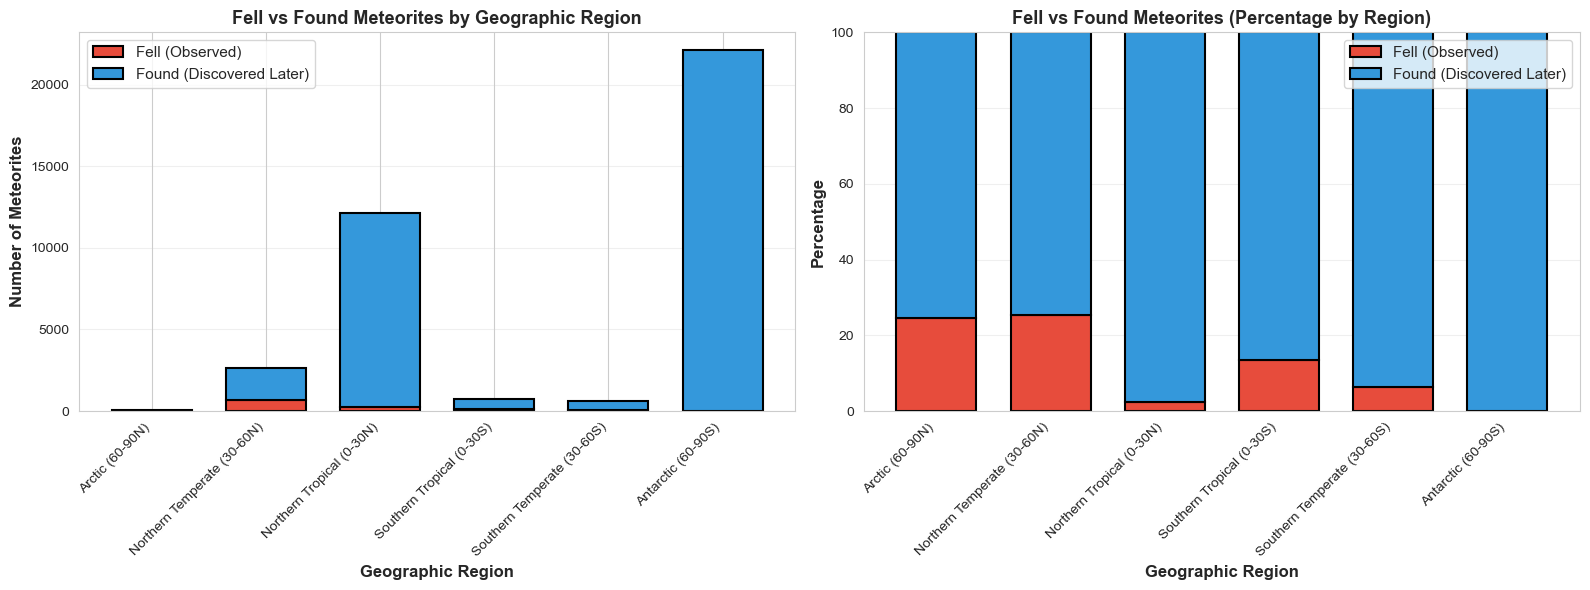


Key Insight: 'Fell' percentage should be higher in populated regions (Northern Temperate/Tropical)
and lower in remote regions (Antarctica, Arctic) - confirming population bias in observations.


In [ ]:
# 1.2: Fell vs Found Geographic Distribution

# Compare "Fell" (observed falling) vs "Found" (discovered later) across regions
fell_found_geo = df_clean.groupby(['lat_band', 'fall']).size().unstack(fill_value=0)

# Calculate percentages
fell_found_pct = fell_found_geo.div(fell_found_geo.sum(axis=1), axis=0) * 100

print("="*70)
print("FELL vs FOUND METEORITES BY GEOGRAPHIC REGION")
print("="*70)
print("\nAbsolute Counts:")
print(fell_found_geo.reindex(lat_order).to_string())

print("\n" + "="*70)
print("Percentage Distribution:")
print(fell_found_pct.reindex(lat_order).round(1).to_string())

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(fell_found_geo)

print(f"\n{'='*70}")
print(f"Statistical Test (Chi-Square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.001:
    print(f"\n✓ HIGHLY SIGNIFICANT difference (p < 0.001)")
    print("The distribution of Fell vs Found is different across geographic regions!")
    print("This confirms that 'Fell' meteorites require human witnesses (population bias).")
else:
    print(f"\n✗ No significant difference (p >= 0.001)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
fell_found_reordered = fell_found_geo.reindex(lat_order)
x = np.arange(len(lat_order))
width = 0.7

axes[0].bar(x, fell_found_reordered['Fell'], width, label='Fell (Observed)', 
           color='#e74c3c', edgecolor='black', linewidth=1.5)
axes[0].bar(x, fell_found_reordered['Found'], width, 
           bottom=fell_found_reordered['Fell'],
           label='Found (Discovered Later)', color='#3498db', edgecolor='black', linewidth=1.5)

axes[0].set_xlabel('Geographic Region', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Meteorites', fontsize=12, fontweight='bold')
axes[0].set_title('Fell vs Found Meteorites by Geographic Region', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(lat_order, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Percentage stacked bar
fell_found_pct_reordered = fell_found_pct.reindex(lat_order)
axes[1].bar(x, fell_found_pct_reordered['Fell'], width, label='Fell (Observed)', 
           color='#e74c3c', edgecolor='black', linewidth=1.5)
axes[1].bar(x, fell_found_pct_reordered['Found'], width,
           bottom=fell_found_pct_reordered['Fell'],
           label='Found (Discovered Later)', color='#3498db', edgecolor='black', linewidth=1.5)

axes[1].set_xlabel('Geographic Region', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[1].set_title('Fell vs Found Meteorites (Percentage by Region)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(lat_order, rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nKey Insight: 'Fell' percentage should be higher in populated regions (Northern Temperate/Tropical)")
print("and lower in remote regions (Antarctica, Arctic) - confirming population bias in observations.")

ANTARCTICA vs REST OF WORLD BY TIME PERIOD
time_period    1800-1899  1900-1949  1950-1969  1970-1989  1990-1999  2000+  Pre-1800
is_antarctica                                                                        
False                663        942        581       1006       4002   8869        60
True                   0          1         12      10762       6772   4552         0


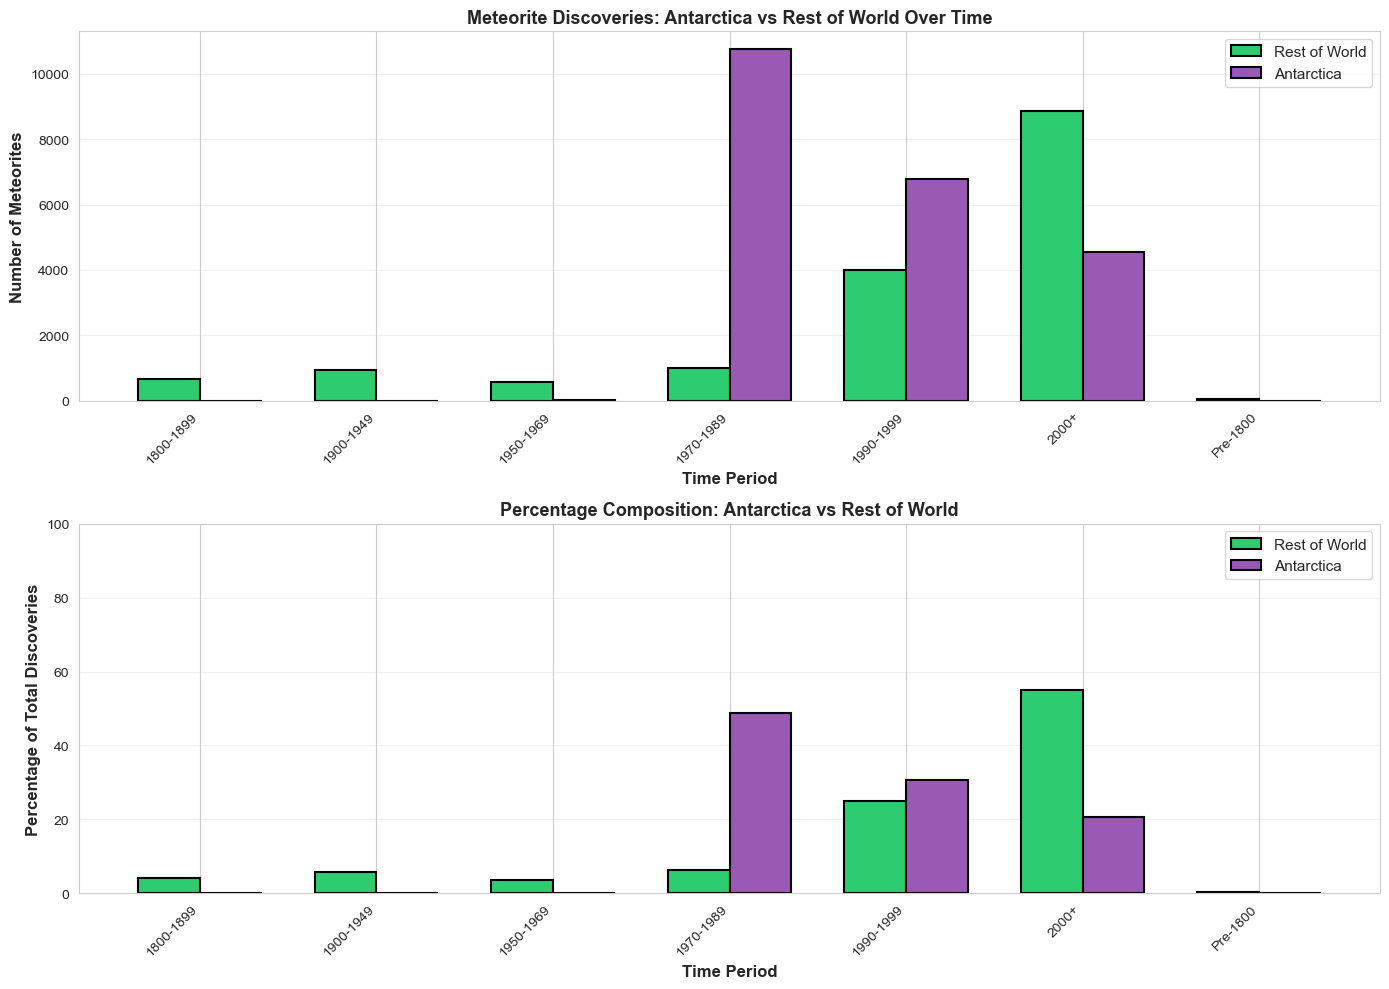


ANTARCTIC DISCOVERY ACCELERATION
Antarctic discoveries before 1970: 13
Antarctic discoveries 1970+: 22086
Growth factor: 1698.9x

This dramatic increase reflects systematic search programs, not actual meteorite distribution!


In [ ]:
# 1.3: Antarctica vs Rest of World - Systematic Search Bias

# Compare Antarctica (systematic searches) vs rest of world
ant_vs_rest = df_clean.groupby(['is_antarctica', 'time_period']).size().unstack(fill_value=0)

print("="*70)
print("ANTARCTICA vs REST OF WORLD BY TIME PERIOD")
print("="*70)
print(ant_vs_rest.to_string())

# Calculate percentages
ant_vs_rest_pct = ant_vs_rest.div(ant_vs_rest.sum(axis=1), axis=0) * 100

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Absolute counts
time_periods = ant_vs_rest.columns.tolist()
x = np.arange(len(time_periods))
width = 0.35

axes[0].bar(x - width/2, ant_vs_rest.loc[False], width, label='Rest of World', 
           color='#2ecc71', edgecolor='black', linewidth=1.5)
axes[0].bar(x + width/2, ant_vs_rest.loc[True], width, label='Antarctica', 
           color='#9b59b6', edgecolor='black', linewidth=1.5)

axes[0].set_xlabel('Time Period', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Meteorites', fontsize=12, fontweight='bold')
axes[0].set_title('Meteorite Discoveries: Antarctica vs Rest of World Over Time', 
                 fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(time_periods, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Percentage composition
axes[1].bar(x - width/2, ant_vs_rest_pct.loc[False], width, label='Rest of World', 
           color='#2ecc71', edgecolor='black', linewidth=1.5)
axes[1].bar(x + width/2, ant_vs_rest_pct.loc[True], width, label='Antarctica', 
           color='#9b59b6', edgecolor='black', linewidth=1.5)

axes[1].set_xlabel('Time Period', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage of Total Discoveries', fontsize=12, fontweight='bold')
axes[1].set_title('Percentage Composition: Antarctica vs Rest of World', 
                 fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(time_periods, rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Calculate growth rates
ant_1970_before = ant_vs_rest.loc[True, ant_vs_rest.columns[ant_vs_rest.columns < '1970-1989']].sum()
ant_1970_after = ant_vs_rest.loc[True, ant_vs_rest.columns[ant_vs_rest.columns >= '1970-1989']].sum()

print(f"\n{'='*70}")
print("ANTARCTIC DISCOVERY ACCELERATION")
print("="*70)
print(f"Antarctic discoveries before 1970: {ant_1970_before}")
print(f"Antarctic discoveries 1970+: {ant_1970_after}")
print(f"Growth factor: {ant_1970_after/ant_1970_before:.1f}x" if ant_1970_before > 0 else "N/A")
print("\nThis dramatic increase reflects systematic search programs, not actual meteorite distribution!")

# Analysis 2: Meteorite Type Distribution - Compositional Patterns

**Research Question:** Do different meteorite types show distinct geographic or temporal patterns?

**Key Hypotheses:**
- Certain meteorite types may cluster geographically (indicating specific parent bodies or collection bias)
- Rare meteorite types may be discovered more recently (better identification methods)
- Antarctica may have different type distributions (systematic collection vs random finds)
- Type diversity should increase over time (better classification methods)

TOP 15 MOST COMMON METEORITE TYPES
recclass
L6             7525
H5             6247
H6             3898
H4             3880
L5             3266
LL5            2199
LL6            1660
L4              939
H4/5            395
CM2             332
H3              313
CO3             308
Iron, IIIAB     270
L3              268
LL              223


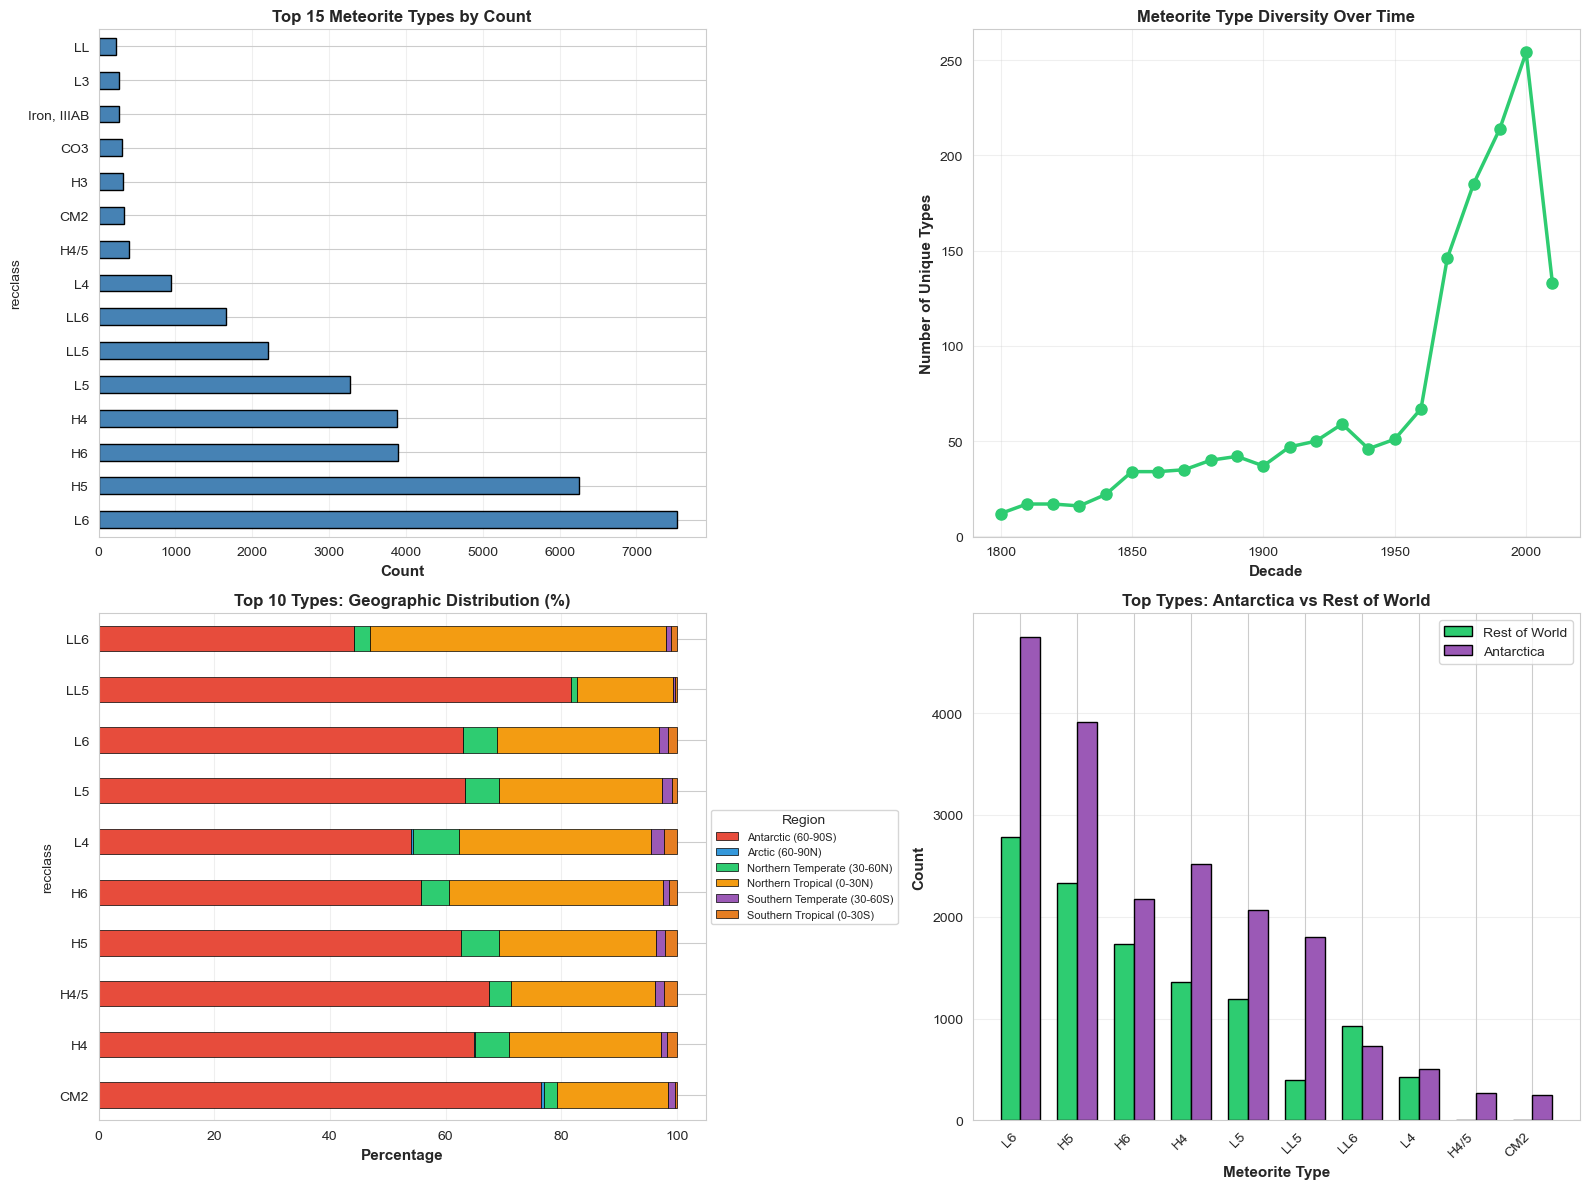


Key Insights:
- Total unique meteorite types: 424
- Type diversity increased from 12 to 254 types
- This reflects both better classification methods and discovery of rare types


In [ ]:
# 2.1: Meteorite Type Distribution Overview

# Get top meteorite types
top_types = df_clean['recclass'].value_counts().head(15)

print("="*70)
print("TOP 15 MOST COMMON METEORITE TYPES")
print("="*70)
print(top_types.to_string())

# Calculate type diversity over time
df_recent_types = df_clean[df_clean['year'] >= 1800].copy()
type_diversity = df_recent_types.groupby('decade')['recclass'].nunique().reset_index()
type_diversity.columns = ['decade', 'unique_types']

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top types bar chart
top_types.plot(kind='barh', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 Meteorite Types by Count', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: Type diversity over time
axes[0, 1].plot(type_diversity['decade'], type_diversity['unique_types'], 
               marker='o', linewidth=2.5, markersize=8, color='#2ecc71')
axes[0, 1].set_xlabel('Decade', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Unique Types', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Meteorite Type Diversity Over Time', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Type distribution by region (top 10 types)
top_10_types = top_types.head(10).index
type_region = df_clean[df_clean['recclass'].isin(top_10_types)].groupby(['recclass', 'lat_band']).size().unstack(fill_value=0)
type_region_pct = type_region.div(type_region.sum(axis=1), axis=0) * 100

type_region_pct.plot(kind='barh', stacked=True, ax=axes[1, 0], 
                    color=[colors_regions.get(col, '#95a5a6') for col in type_region_pct.columns],
                    edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel('Percentage', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 10 Types: Geographic Distribution (%)', fontsize=12, fontweight='bold')
axes[1, 0].legend(title='Region', fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Antarctica vs Rest - Type comparison
ant_types = df_clean[df_clean['is_antarctica'] == True]['recclass'].value_counts().head(10)
rest_types = df_clean[df_clean['is_antarctica'] == False]['recclass'].value_counts().head(10)

x_pos = np.arange(len(top_10_types))
width = 0.35
ant_counts = [ant_types.get(t, 0) for t in top_10_types]
rest_counts = [rest_types.get(t, 0) for t in top_10_types]

axes[1, 1].bar(x_pos - width/2, rest_counts, width, label='Rest of World', 
              color='#2ecc71', edgecolor='black', linewidth=1)
axes[1, 1].bar(x_pos + width/2, ant_counts, width, label='Antarctica', 
              color='#9b59b6', edgecolor='black', linewidth=1)
axes[1, 1].set_xlabel('Meteorite Type', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top Types: Antarctica vs Rest of World', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(top_10_types, rotation=45, ha='right')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"- Total unique meteorite types: {df_clean['recclass'].nunique()}")
print(f"- Type diversity increased from {type_diversity['unique_types'].min()} to {type_diversity['unique_types'].max()} types")
print(f"- This reflects both better classification methods and discovery of rare types")

# Analysis 3: Mass Distribution - Survivability & Discovery Bias

**Research Question:** What patterns in meteorite mass reveal about atmospheric entry, survivability, and discovery methods?

**Key Hypotheses:**
- Larger meteorites may survive better in certain environments (deserts vs ice)
- Average mass of discovered meteorites may have changed over time (better detection of small ones)
- Geographic regions may show different mass distributions (collection bias)
- Mass may correlate with meteorite type (different parent bodies)

MASS DISTRIBUTION OVERVIEW
Total meteorites with mass data: 38114 (99.7%)
Mass range: 0.00g to 6.00e+07g
Median mass: 29.09g (0.0291kg)
Mean mass: 1.56e+04g (15.60kg)

MASS STATISTICS BY GEOGRAPHIC REGION (kg)
                             count      mean  median    q25     q75
lat_band                                                           
Arctic (60-90N)                 56  1104.273   3.375  0.535  25.875
Northern Temperate (30-60N)   2582    68.801   1.900  0.161  11.000
Northern Tropical (0-30N)    12090     9.412   0.097  0.017   0.400
Southern Tropical (0-30S)      698   276.839   0.432  0.065   6.498
Southern Temperate (30-60S)    591    74.834   0.125  0.031   2.250
Antarctic (60-90S)           22097     0.176   0.013  0.004   0.049


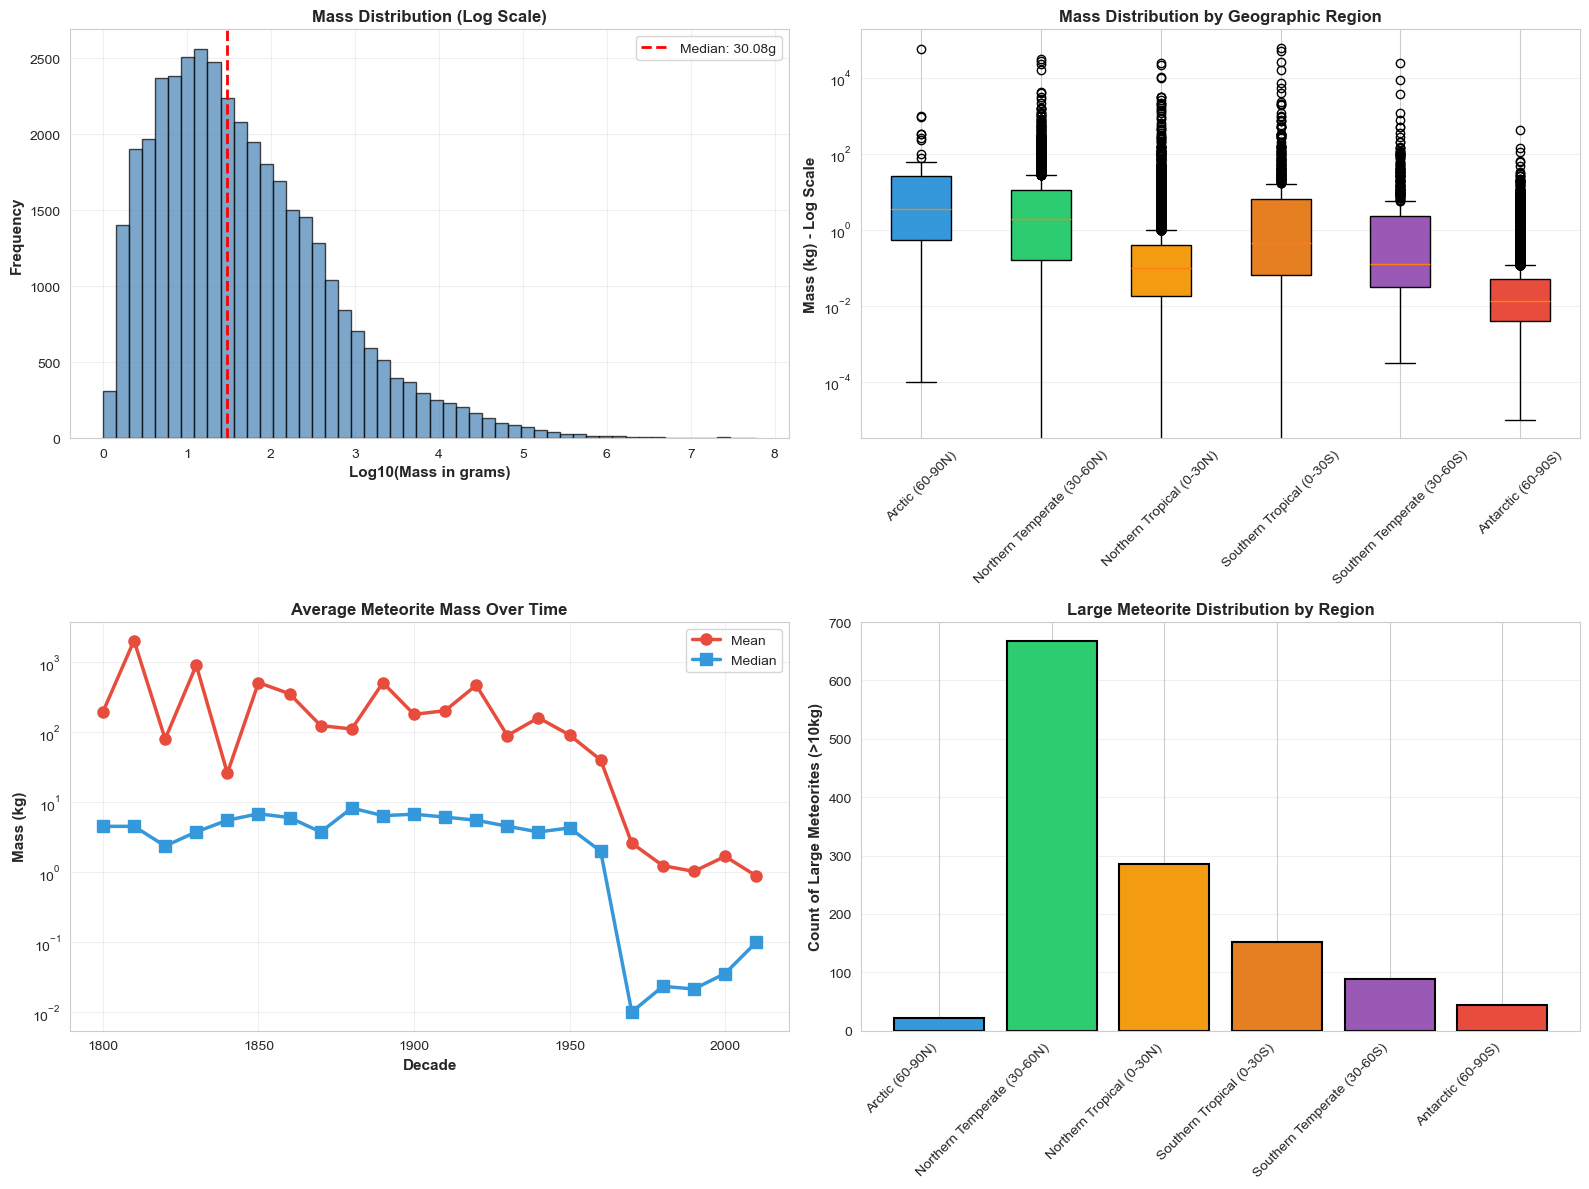


Statistical Test (Kruskal-Wallis):
H-statistic: 8809.5181
P-value: 0.0000e+00

✓ SIGNIFICANT difference in mass distribution across regions!


In [ ]:
# 3.1: Mass Distribution Analysis

# Clean mass data
mass_df = df_clean[df_clean['mass (g)'].notna()].copy()
mass_df['mass_kg'] = mass_df['mass (g)'] / 1000
mass_df['log_mass'] = np.log10(mass_df['mass (g)'] + 1)  # Add 1 to avoid log(0)

print("="*70)
print("MASS DISTRIBUTION OVERVIEW")
print("="*70)
print(f"Total meteorites with mass data: {len(mass_df)} ({len(mass_df)/len(df_clean)*100:.1f}%)")
print(f"Mass range: {mass_df['mass (g)'].min():.2f}g to {mass_df['mass (g)'].max():.2e}g")
print(f"Median mass: {mass_df['mass (g)'].median():.2f}g ({mass_df['mass_kg'].median():.4f}kg)")
print(f"Mean mass: {mass_df['mass (g)'].mean():.2e}g ({mass_df['mass_kg'].mean():.2f}kg)")

# Calculate mass statistics by region
mass_by_region = mass_df.groupby('lat_band')['mass_kg'].agg([
    'count', 'mean', 'median', 
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
])

print(f"\n{'='*70}")
print("MASS STATISTICS BY GEOGRAPHIC REGION (kg)")
print("="*70)
print(mass_by_region.reindex(lat_order).round(3).to_string())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mass distribution histogram (log scale)
axes[0, 0].hist(mass_df['log_mass'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(mass_df['log_mass'].median(), color='red', linestyle='--', 
                  linewidth=2, label=f'Median: {10**mass_df["log_mass"].median():.2f}g')
axes[0, 0].set_xlabel('Log10(Mass in grams)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Mass Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Box plot by region
mass_by_region_list = [mass_df[mass_df['lat_band'] == region]['mass_kg'].values 
                        for region in lat_order if region in mass_df['lat_band'].unique()]
bp = axes[0, 1].boxplot(mass_by_region_list, labels=[r for r in lat_order if r in mass_df['lat_band'].unique()],
                       patch_artist=True)
for patch, color in zip(bp['boxes'], [colors_regions.get(col, '#95a5a6') for col in lat_order if col in mass_df['lat_band'].unique()]):
    patch.set_facecolor(color)
axes[0, 1].set_yscale('log')
axes[0, 1].set_ylabel('Mass (kg) - Log Scale', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Mass Distribution by Geographic Region', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Mean mass over time
mass_temporal = mass_df[mass_df['year'] >= 1800].groupby('decade')['mass_kg'].agg(['mean', 'median', 'count'])
axes[1, 0].plot(mass_temporal.index, mass_temporal['mean'], marker='o', linewidth=2.5, 
               markersize=8, label='Mean', color='#e74c3c')
axes[1, 0].plot(mass_temporal.index, mass_temporal['median'], marker='s', linewidth=2.5, 
               markersize=8, label='Median', color='#3498db')
axes[1, 0].set_xlabel('Decade', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Mass (kg)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Meteorite Mass Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Large meteorites (>10kg) by region
large_threshold = 10  # kg
large_meteorites = mass_df[mass_df['mass_kg'] > large_threshold].groupby('lat_band').size()
large_meteorites = large_meteorites.reindex(lat_order, fill_value=0)
axes[1, 1].bar(range(len(large_meteorites)), large_meteorites.values,
              color=[colors_regions.get(col, '#95a5a6') for col in large_meteorites.index],
              edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(large_meteorites)))
axes[1, 1].set_xticklabels(large_meteorites.index, rotation=45, ha='right')
axes[1, 1].set_ylabel(f'Count of Large Meteorites (>{large_threshold}kg)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Large Meteorite Distribution by Region', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical test for mass differences across regions
groups = [mass_df[mass_df['lat_band'] == region]['mass_kg'].values 
          for region in lat_order if region in mass_df['lat_band'].unique()]

if len(groups) > 2:
    h_stat, p_value = kruskal(*groups)
    print(f"\n{'='*70}")
    print(f"Statistical Test (Kruskal-Wallis):")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    if p_value < 0.05:
        print(f"\n✓ SIGNIFICANT difference in mass distribution across regions!")
    else:
        print(f"\n✗ No significant difference in mass distribution.")

# Summary & Key Findings

## Overall Insights

This exploratory data analysis investigated **geographic and temporal patterns** in meteorite discoveries to understand how human activity, rather than actual meteorite distribution, shapes what we find.

### Key Findings:

1. **Discovery Bias is Pervasive**
   - Geographic distribution heavily influenced by human population density
   - "Fell" (observed) meteorites cluster in populated regions
   - Antarctica shows dramatic increase post-1970s due to systematic search programs

2. **Temporal Evolution Reveals Collection Methods**
   - Discovery rates accelerated dramatically in late 20th century
   - Antarctic expeditions fundamentally changed discovery patterns
   - Type diversity increased over time (better classification + rare type discovery)

3. **Mass Distribution Shows Environmental & Collection Bias**
   - Mass patterns vary by geographic region
   - Temporal trends may reflect changing detection capabilities
   - Large meteorites may be easier to find in certain environments

### Implications:

- **Scientific Interpretation**: Meteorite collections are NOT representative of actual meteorite distribution
- **Sampling Bias**: Understanding bias is crucial for planetary science research
- **Collection Strategy**: Future searches should account for these biases
- **Data Quality**: Historical data quality and completeness varies significantly


## Next Steps & Extensions

### Possible Extensions:

1. **Population Density Analysis**
   - Overlay discovery locations with population density maps
   - Quantify correlation between discoveries and human population

2. **Desert vs Ice Collection**
   - Compare systematic desert searches (Sahara, Atacama) with Antarctic searches
   - Analyze type distributions in different collection environments

3. **Rare Type Analysis**
   - Focus on rare meteorite types and their discovery patterns
   - Identify potential parent body connections

4. **Combined NEO Analysis**
   - Link Near-Earth Object orbital data with meteorite types
   - Identify potential source asteroids

5. **Machine Learning Applications**
   - Predict discovery locations based on environmental factors
   - Classify meteorite types from geographic/temporal patterns

### Data Improvements:

- Add elevation/altitude data for all meteorites
- Include collection method metadata
- Link to parent body identification data
- Add weathering/terrestrial age information